In [1]:
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys
sys.path.append('/dfs/scratch0/vschen/metal')

In [3]:
import warnings
warnings.filterwarnings('ignore')

## Generate Data

In [4]:
seed = 312

import random
np.random.seed(seed)
random.seed(seed)

In [5]:
from simulate import data_config
from synthetics_utils import generate_synthetic_data
from visualization_utils import visualize_data, display_scores, plot_slice_scores

In [6]:
def generate_uniform_circle_data(n, center, radius):
    length = np.sqrt(np.random.uniform(0, 1, n)) * radius
    angle = np.pi * np.random.uniform(
        0, 2, n
    )  # cover full range from 0 to 2pi
    x = length * np.cos(angle) + center[0]
    y = length * np.sin(angle) + center[1]
    return np.vstack((x, y)).T


def get_circle_idx(X, center, radius):
    h, k = center
    idx = np.sqrt((X[:, 0] - h) ** 2 + (X[:, 1] - k) ** 2) < radius
    return idx

def radius_for_lf_recall(target_recall, slice_radius):
    assert isinstance(slice_radius, int) or isinstance(slice_radius, float)
    return np.sqrt(target_recall * (slice_radius**2))

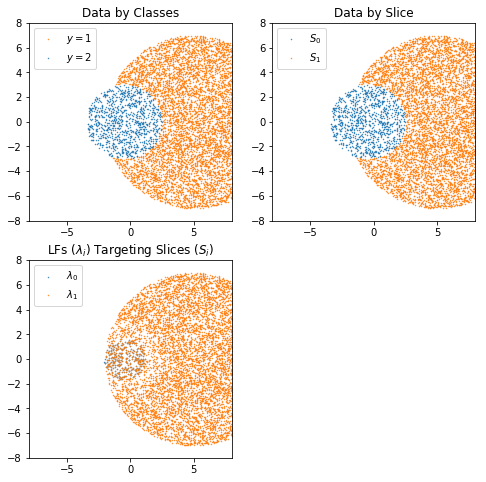

In [7]:
from synthetics_utils import shuffle_matrices

config = {
 'N': 10000,
 'mus': np.array([[-0.5,  0], [5, 0]]),
 'variances': [3, 7],
#  'mus': np.array([[0.5,  0], [5, 0]]),
#  'variances': [2.2, 7],
 'labels': [2, 1],
 'props': [0.1, 0.9],
 'lf_recalls': [1.0, 1.0],
 'mv_normal': False
}

def generate_simple_data(config, x_var=None, x_val=None, verbose=False, return_overlap=False):        
    centers = config['mus']
    radii = config['variances']
    class_props = config['props']
    N = config['N']
    labels = config['labels']
    lf_recalls = config['lf_recalls']

    # overwrite recall value for head lf
    if x_var == 'cov.recall':
        lf_recalls[0] = x_val
    
    # Set slice 1
    n_per_slice = [int(N*prop) for prop in class_props]
    slice_1 = generate_uniform_circle_data(
        n_per_slice[1], 
        centers[1], 
        radii[1]
    )

    # get idx for slice 0 within slice 1
    slice_0_idx = get_circle_idx(slice_1, tuple(centers[0]), radii[0])

    # remove slice 0 idx from slice 1
    # NOTE: because we remove the slice, if the variances are not 
    # proportional to the slice size, the original props will not be maintained
    slice_1 = slice_1[np.logical_not(slice_0_idx)]
    n_per_slice[1] = len(slice_1)

    # Set slice 0
    slice_0 = generate_uniform_circle_data(
        n_per_slice[0], 
        centers[0], 
        radii[0]
    )

    # combine slices
    Xu = [slice_0, slice_1] # data points
    Yu = [label * np.ones(n) for n, label in zip(n_per_slice, labels)] # class labels
    Cu = [i * np.ones(n) for i, n in enumerate(n_per_slice)] # slice labels

    X, Y, C = shuffle_matrices([np.vstack(Xu), np.hstack(Yu), np.hstack(Cu)])
    
    # generate label matrix
    L = np.zeros((sum(n_per_slice), 2))

    # set LF0
    lf_0_idx = get_circle_idx(
        X, 
        tuple(centers[0]), 
        radius_for_lf_recall(lf_recalls[0], radii[0])
    )
    L[lf_0_idx, 0] = labels[0]
    
    # set LF1 to perfectly target slice
    lf_1_idx = get_circle_idx(
        X, 
        tuple(centers[1]), 
        radius_for_lf_recall(lf_recalls[1], radii[1])
    )
    L[lf_1_idx, 1] = labels[1]

    overlap_idx = np.logical_and(lf_0_idx, lf_1_idx)
    
    if return_overlap:
        return X, Y, C, L, overlap_idx
    
    return X, Y, C, L


X, Y, C, L, overlap_idx = generate_simple_data(config, x_var='cov.recall', x_val=0.3, return_overlap=True)
# mask = C==1
mask = overlap_idx
# X = X[mask]
# Y = Y[mask]
# L = L[mask]
# C = C[mask]

visualize_data(X, Y, C, L)

In [8]:
np.unique(L, return_counts=True), np.unique(Y, return_counts=True)

((array([0., 1., 2.]), array([8612, 8509,  329])),
 (array([1., 2.]), array([7725, 1000])))

In [9]:
np.unique(L.sum(axis=1), return_counts=True)

(array([0., 1., 2., 3.]), array([ 212, 8184,    4,  325]))

In [10]:
from simulate import simulate, experiment_config
split_idx = int(len(X) * experiment_config["train_prop"])
X = torch.from_numpy(X.astype(np.float32))
L = L.astype(np.float32)
Y = Y.astype(np.float32)
X_train, X_test = X[:split_idx], X[split_idx:]
Y_train, Y_test = Y[:split_idx], Y[split_idx:]  # no gt train data!
L_train, L_test = L[:split_idx], L[split_idx:]
C_train, C_test = C[:split_idx], C[split_idx:]
overlap_train, overlap_test = overlap_idx[:split_idx], overlap_idx[split_idx:]

[1.0, 0.9045667447306791]


(array([4.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.580e+02,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.750e+02, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 6.543e+03]),
 array([0.00276243, 0.03563675, 0.06851106, 0.10138538, 0.1342597 ,
        0.16713401, 0.20000833, 0.23288265, 0.26575697, 0.29863128,
        0.3315056 , 0.36437992, 0.39725423, 0.43012855, 0.46300287,
        0.49587718, 0.5287515 , 0.56162582, 0.59450013, 0.62737445,
        0.66024877, 0.69312308, 0.7259974 , 0.75887172, 0.79174603,
        0.82462035, 0.85749467, 0.89036898, 0.9232433 , 0.95611762,
        0.98899193]),
 <a list of 30 Patch objects>)

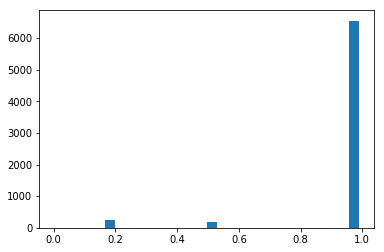

In [11]:
accs = []
from metal.metrics import accuracy_score
for lf_idx in range(L_train.shape[1]):
    voted_idx = L_test[:, lf_idx] != 0
    accs.append(accuracy_score(L_test[voted_idx, lf_idx], Y_test[voted_idx]))

print (accs)

# accs = np.array([0.9, 0.1]).astype(np.float32)
from metal.contrib.slicing.experiment_utils import generate_weak_labels
Y_tilde_accs = generate_weak_labels(L_train, np.array(accs))
plt.hist(Y_tilde_accs[:, 0], 30)

(array([1.750e+02, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 4.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        6.543e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 2.580e+02]),
 array([0.5       , 0.50348996, 0.50697991, 0.51046987, 0.51395983,
        0.51744978, 0.52093974, 0.52442969, 0.52791965, 0.53140961,
        0.53489956, 0.53838952, 0.54187948, 0.54536943, 0.54885939,
        0.55234935, 0.5558393 , 0.55932926, 0.56281922, 0.56630917,
        0.56979913, 0.57328908, 0.57677904, 0.580269  , 0.58375895,
        0.58724891, 0.59073887, 0.59422882, 0.59771878, 0.60120874,
        0.60469869]),
 <a list of 30 Patch objects>)

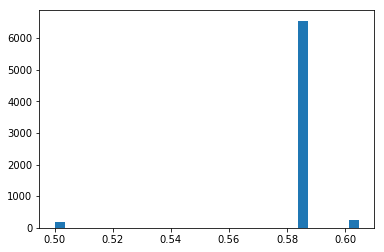

In [12]:
Y_tilde_metal = generate_weak_labels(L_train)
plt.hist(Y_tilde_metal[:, 0], 30)

### Validating that we can reproduce the L matrix 
Train attention model with `slice_weight=1.0`. Then, try to repredict the `L_test` values using the `L_head`.

In [13]:
from metal.end_model import EndModel
from metal.contrib.slicing.online_dp import LinearModule, MLPModule, SliceDPModel

model_configs = {
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 1.0, # NOTE: slice weight 1.0 means we are only backprop on L_head
            "L_weights": None
        },
#         "input_module_class": LinearModule,
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

In [14]:
from simulate import train_models

# DEBUG: gt labels for training [prob_1, prob2]
Y_cat = np.zeros((Y_train.shape[0], 2))
Y_cat[:,0] = Y_train == 1
Y_cat[:,1] = Y_train == 2
Y_cat = Y_cat.astype(np.float32)

config['accs'] = np.array(accs)
# config['accs'] = np.array([1.0, 1.0])
experiment_config['use_weak_labels_from_gen_model'] = True
experiment_config['x_var'] = None
experiment_config['num_trials'] = 1
experiment_config['verbose'] = True
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 20
experiment_config['seed'] = 222

trained_models = train_models(
    X_train,
    L_train,
    Y_tilde_accs,
    (X_test, Y_test),
    model_configs,
    experiment_config["train_kwargs"],
    verbose=experiment_config["verbose"],
    seed=experiment_config.get("seed", None)
)


---------- Training AttentionModel ----------
Slice Heads:
Reweighting: True
L_weights: tensor([[1.],
        [1.]])
Slice Weight: 1.0
Input Network: Sequential(
  (0): MLPModule(
    (input_layer): Sequential(
      (0): Linear(in_features=2, out_features=5, bias=True)
      (1): ReLU()
      (2): Linear(in_features=5, out_features=5, bias=True)
      (3): ReLU()
    )
  )
)
L_head: Linear(in_features=5, out_features=2, bias=False)
Y_head: Linear(in_features=10, out_features=2, bias=False)
Criteria: BCEWithLogitsLoss() SoftCrossEntropyLoss()
Hardcoding 2 -> cat labels
No checkpoints will be saved in the first checkpoint_runway=5 iterations.
[E:0]	Train Loss: 0.015	Dev accuracy: 0.620
[E:1]	Train Loss: 0.003	Dev accuracy: 0.885
[E:2]	Train Loss: 0.002	Dev accuracy: 0.885
[E:3]	Train Loss: 0.002	Dev accuracy: 0.885
[E:4]	Train Loss: 0.002	Dev accuracy: 0.885
Saving model at iteration 5 with best score 0.885
[E:5]	Train Loss: 0.002	Dev accuracy: 0.885
[E:6]	Train Loss: 0.002	Dev accuracy

In [15]:
import torch.nn.functional as F
# X_test_L_head = X_train
# L_test_L_head = L_train
# overlap_test_L_head = overlap_train

X_test_L_head = X_test
L_test_L_head = L_test
overlap_test_L_head = overlap_test


slice_preds = F.sigmoid(
    trained_models['AttentionModel'].forward_L(X_test_L_head)
).detach().numpy()


preds = (slice_preds > 0.5) * 1
L_gt = L_test_L_head.copy()
L_gt[L_gt != 0] = 1
print ('predicted L distribution:', np.sum(preds, axis=0))
print ('accuracy over LF0:', accuracy_score(L_gt[:, 0], preds[:, 0]))
print ('accuracy over LF1:', accuracy_score(L_gt[:, 1], preds[:, 1]))

print ('accuracy over overlap for LF 0:', 
       accuracy_score(L_gt[overlap_test_L_head, 0], preds[overlap_test_L_head, 0]))

print ('accuracy over overlap for LF 1:', 
      accuracy_score(L_gt[overlap_test_L_head, 1], preds[overlap_test_L_head, 1]))


predicted L distribution: [  37 1705]
accuracy over LF0: 0.9507163323782235
accuracy over LF1: 0.9902578796561604
accuracy over overlap for LF 0: 0.13432835820895522
accuracy over overlap for LF 1: 0.8656716417910447


### Compare EndModel to AttentionModel

In [16]:
model_configs = {
    "EndModel": {
        "base_model_class" : EndModel,
        "base_model_init_kwargs": {
            "layer_out_dims": [5, 2],
            "input_layer_config": {
                "input_relu": False,
                "input_batchnorm": False,
                "input_dropout": 0.0,
            }
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        
        "train_on_L": False
    },
    "AttentionModel": {
        "base_model_class" : SliceDPModel,
        "base_model_init_kwargs": {
            "reweight": True,
            "r": 5,
            "slice_weight": 0.1,
            "L_weights": None
        },
        "input_module_class": MLPModule,
        "input_module_init_kwargs": {
            'input_dim': 2,
            'middle_dims': [5],
            'bias': True,
            'output_dim': 5
         },
        "train_on_L": True,
    }
}

Simulating: cov.recall=0.0


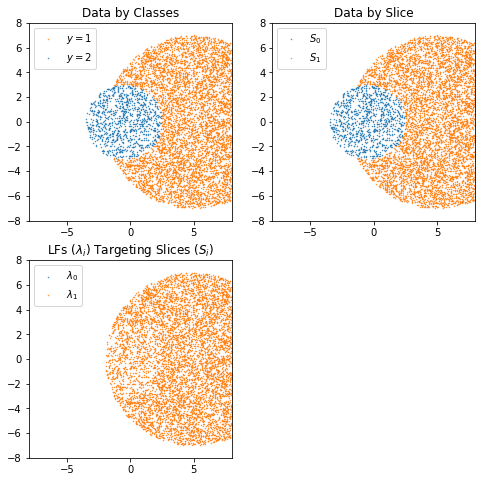

Hardcoding 2 -> cat labels


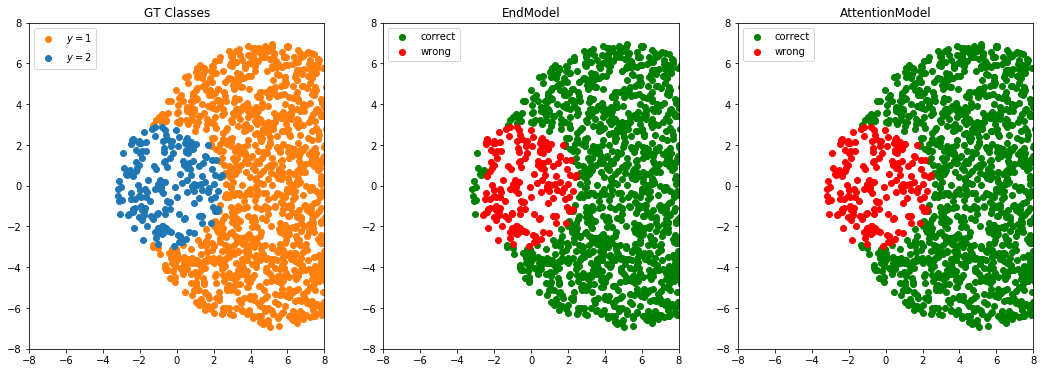

Simulating: cov.recall=0.1111111111111111


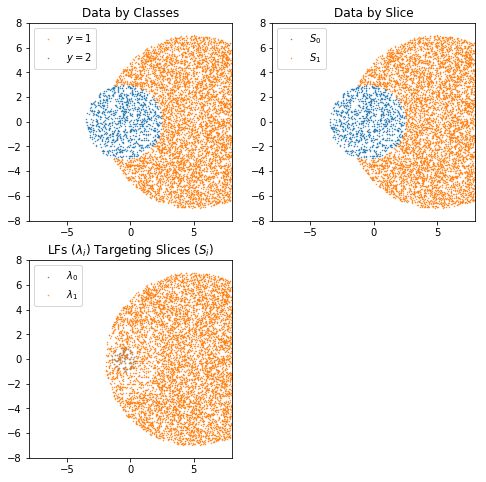

Hardcoding 2 -> cat labels


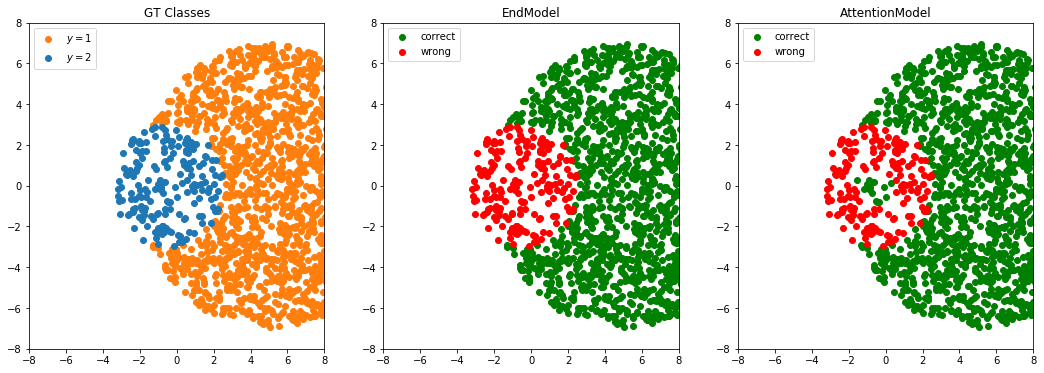

Simulating: cov.recall=0.2222222222222222


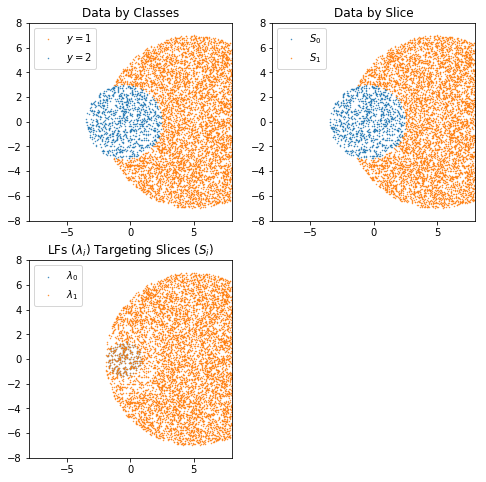

Hardcoding 2 -> cat labels


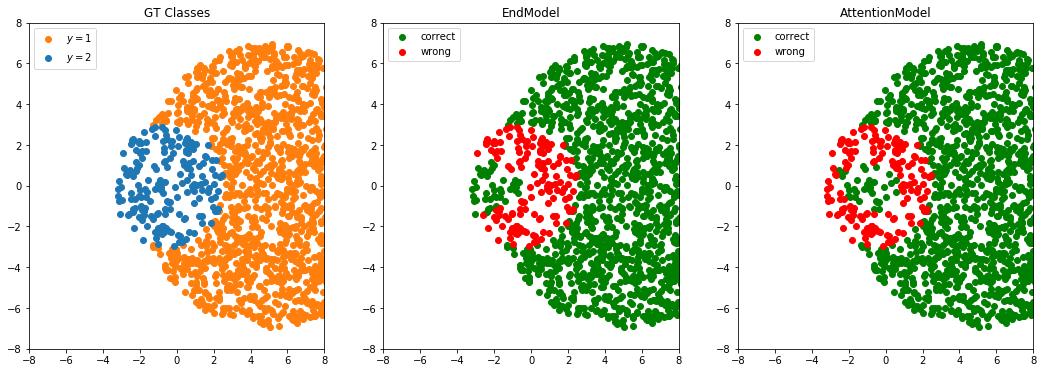

Simulating: cov.recall=0.3333333333333333


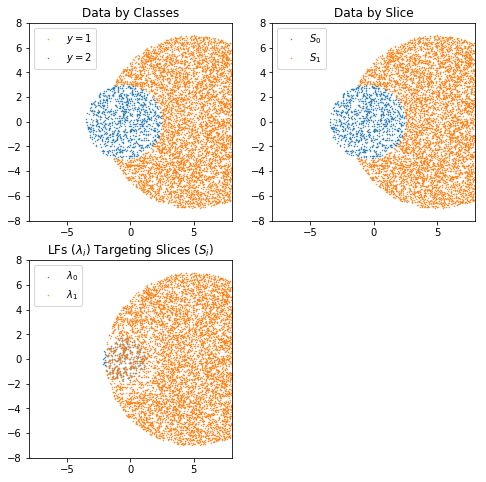

Hardcoding 2 -> cat labels


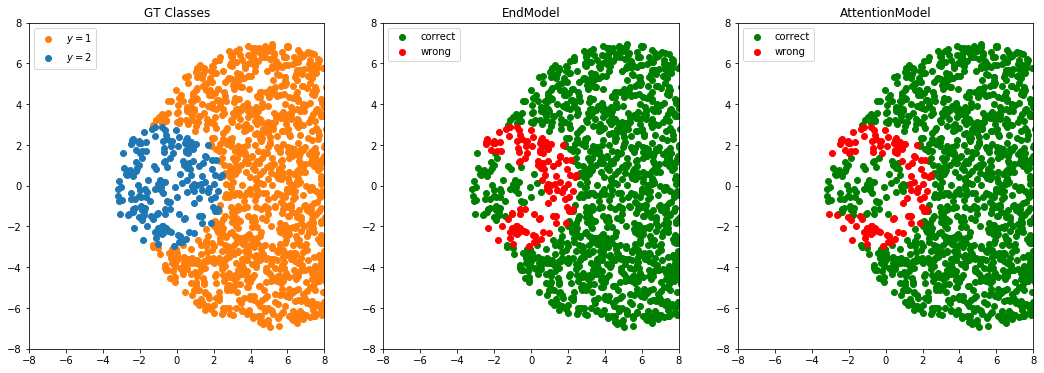

Simulating: cov.recall=0.4444444444444444


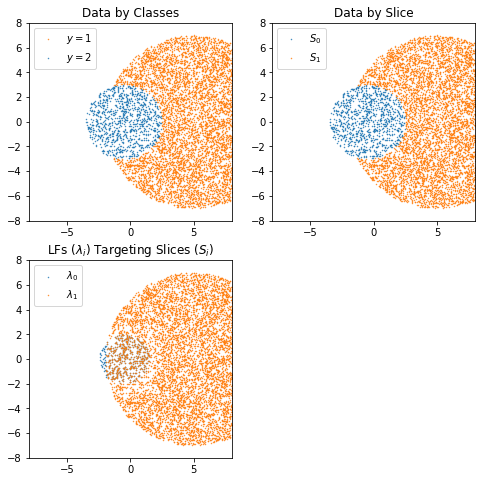

Hardcoding 2 -> cat labels


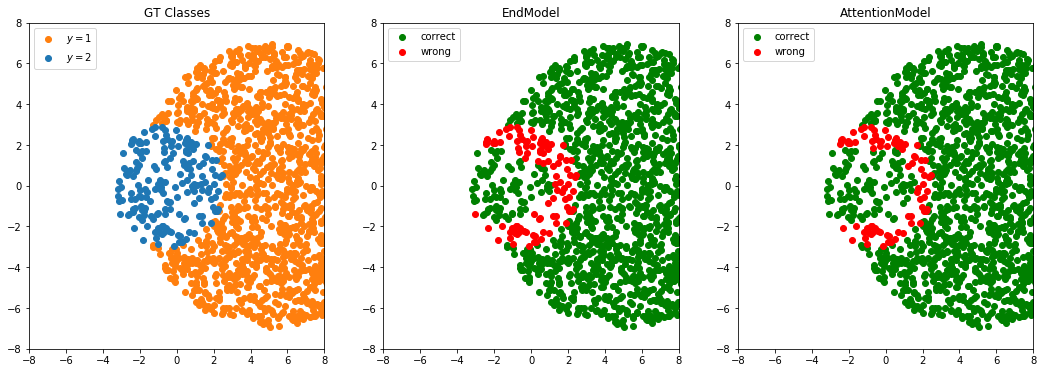

Simulating: cov.recall=0.5555555555555556


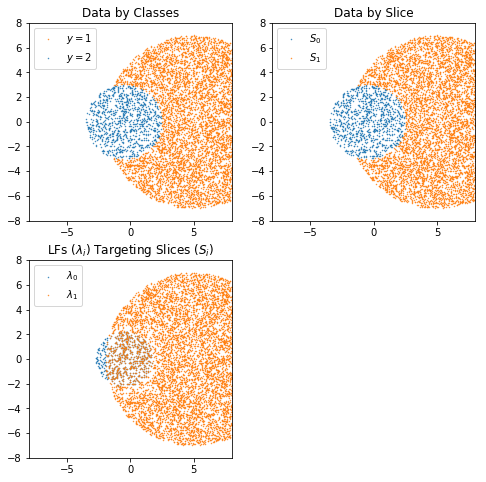

Hardcoding 2 -> cat labels


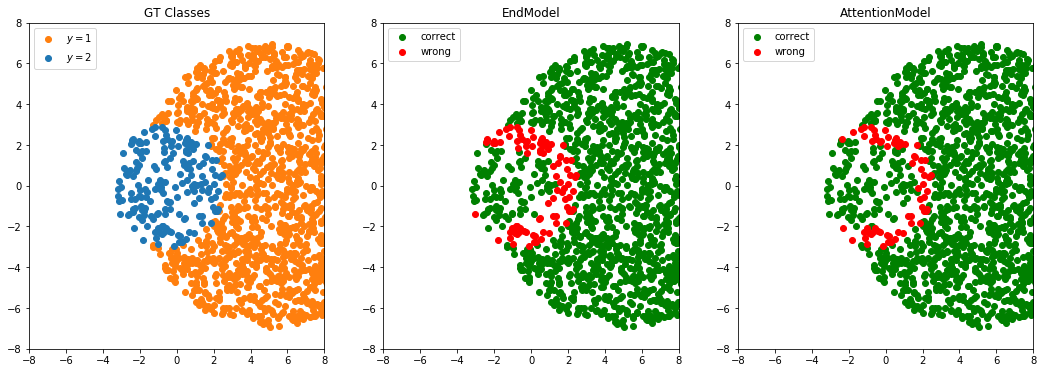

Simulating: cov.recall=0.6666666666666666


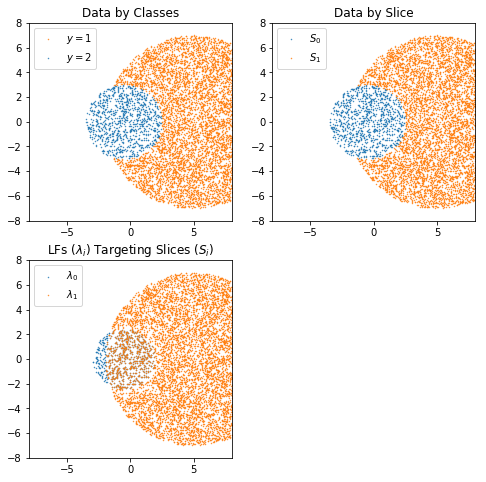

Hardcoding 2 -> cat labels


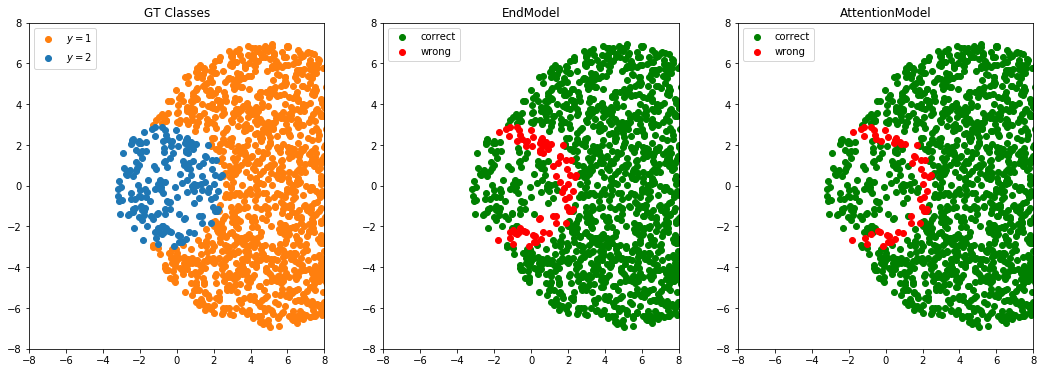

Simulating: cov.recall=0.7777777777777777


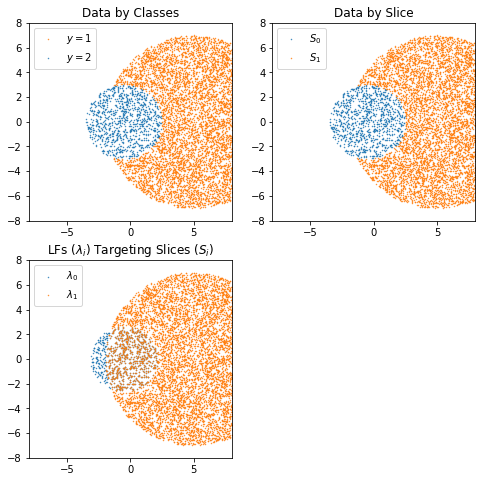

Hardcoding 2 -> cat labels


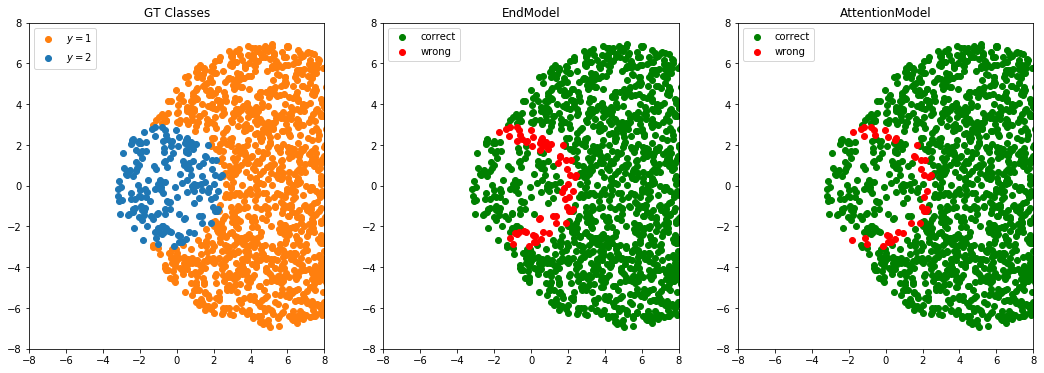

Simulating: cov.recall=0.8888888888888888


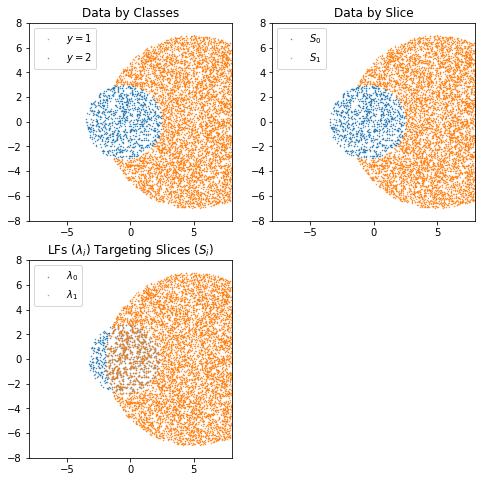

Hardcoding 2 -> cat labels


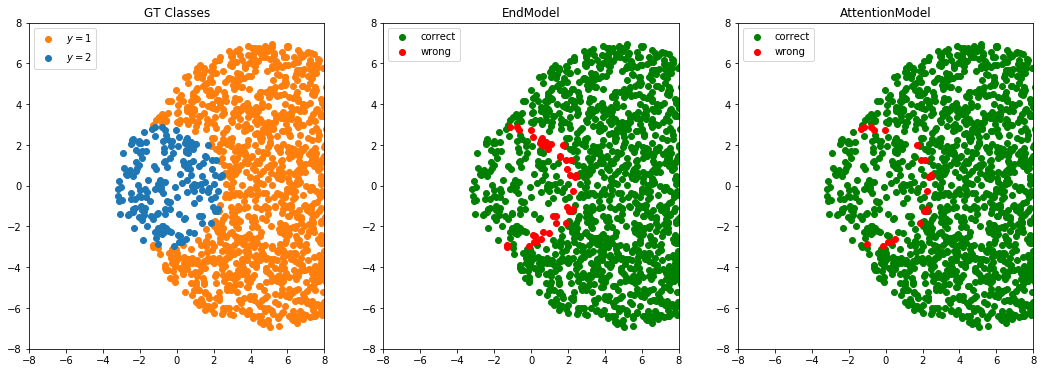

Simulating: cov.recall=1.0


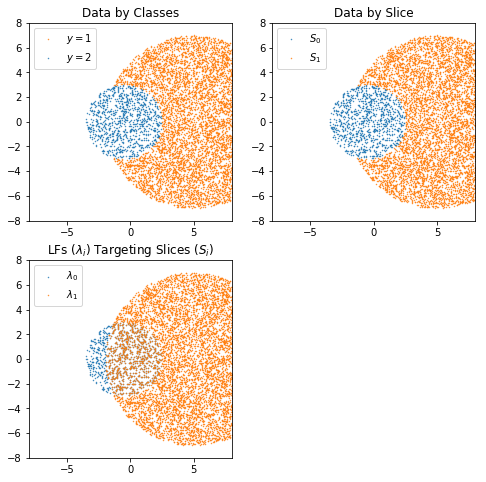

Hardcoding 2 -> cat labels


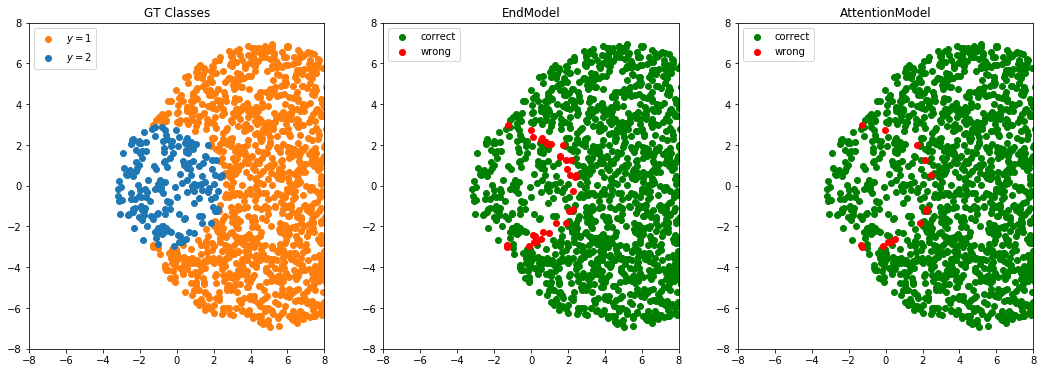

defaultdict(<function simulate.simulate.<locals>.<lambda>()>,
            {'EndModel': defaultdict(list,
                         {0.0: [{'S0': 0.07027027027027027,
                            'S1': 1.0,
                            'overall': 0.9012062033314188}],
                          0.1111111111111111: [{'S0': 0.0,
                            'S1': 1.0,
                            'overall': 0.893739230327398}],
                          0.2222222222222222: [{'S0': 0.23243243243243245,
                            'S1': 1.0,
                            'overall': 0.9184376794945434}],
                          0.3333333333333333: [{'S0': 0.35135135135135137,
                            'S1': 1.0,
                            'overall': 0.9310740953475014}],
                          0.4444444444444444: [{'S0': 0.4594594594594595,
                            'S1': 1.0,
                            'overall': 0.9425617461229179}],
                          0.5555555555555556: [{'S0':

In [18]:
from simulate import simulate, experiment_config
config['accs'] = np.array(accs)
experiment_config['use_weak_labels_from_gen_model'] = False
# experiment_config['x_var'] = None
experiment_config['x_var'] = 'cov.recall'
experiment_config['x_range'] = np.linspace(0, 1, 10)
experiment_config['num_trials'] = 1
experiment_config['verbose'] = False
experiment_config['visualize_data'] = True
experiment_config['train_kwargs']['print_every'] = 1
experiment_config['train_kwargs']['l2'] = 0
experiment_config['train_kwargs']['lr'] = 0.001
experiment_config['train_kwargs']['n_epochs'] = 40
experiment_config['plot_predictions'] = ['EndModel', 'AttentionModel']

experiment_config['seed'] = 111
scores = \
    simulate(config, generate_simple_data, experiment_config, model_configs)
scores

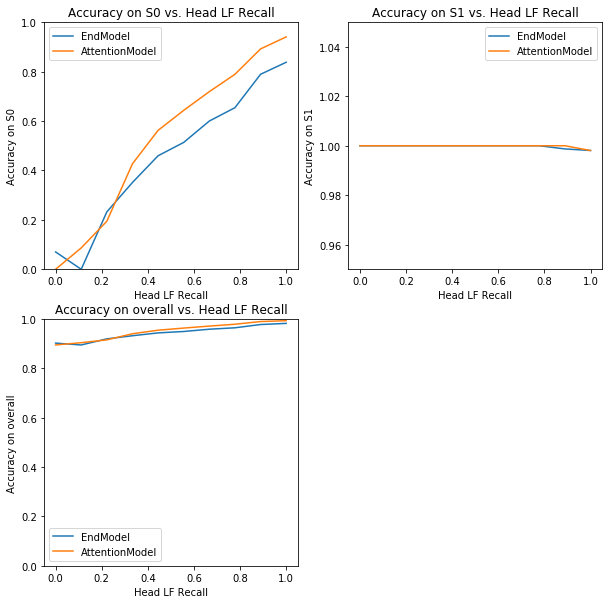

In [19]:
plot_slice_scores(scores, xlabel="Head LF Recall", custom_ylims={'S1': [0.95, 1.05]})